# Using GANs to Generate Anime Face Images for Video Games or Anime

Generative Adversarial Networks (GANs) have revolutionized various fields by enabling the creation of realistic synthetic data. In this project, we aim to generate anime face images using GANs, which can be utilized in video games or anime productions.


## Problem Definition

Machine learning technology is considered a game changer in almost every industry as it has helped automate various processes, such as writing stories and differentiating between different faces, among other things. Dave Waters perfectly sums up how machine learning will impact us by saying, “Machine learning will automate jobs that most people thought could only be done by people.”

The problem I will be focusing on in this paper stems from my personal experience with creating art. I have recently gotten into game development, but in the process of making games, I always find problems when it comes to designing my characters, as I am not particularly an artsy person. I could potentially download pre-made models, but this would not feel right to me as I would still be using someone else’s work. From my experience, I understand how important the Arts and Design department is for a video game development company. However, Dave Waters's quote got me thinking: maybe there is a way to mitigate the need for an artsy person. Maybe I do not need a person to create art for me but can utilize machine learning to do that instead.

However, I soon realized how long it takes to train a model well for big images, so I had to tone down my ambition and focus on smaller images that would not take as long to run but could still relate to my problem. Then it hit me: why not generate anime faces? There is a dataset available for this with the perfect size. Connecting back to my initial curiosity about concept art generation, this can relate well, as anime characters are often used in video games. This small thought led me to pursue this particular final project.


## Checking GPU Availability

Before starting the training process, we need to check the availability of GPUs to ensure that our model can leverage hardware acceleration.

In [89]:
import tensorflow as tf

# Check the number of available GPUs
num_gpus = len(tf.config.list_physical_devices('GPU'))
print("Number of GPUs Available: ", num_gpus)

Number of GPUs Available:  1


## Solution Specification

To create my model, I first obtained the dataset from Kaggle (link in references). After that, I preprocessed the images to make them suitable for my use.

The main idea for this model is to have two separate models: one that generates images (the generator) and another that checks if the images are real or fake (the discriminator). This model is a type of adversarial model because the two models, the generative and the discriminative models, are playing a zero-sum game where if one wins, the other is forced to update itself. The generative model can be thought of as an art forger, while the discriminator acts as an art critic.

### Data Preprocessing

In this section, we will preprocess the images from the dataset to prepare them for use in the GAN model. The images will be resized to 28x28 pixels and normalized.

In [90]:
from PIL import Image
import os
import numpy as np

# Folder containing the images
folder = 'images'

# Function to read and preprocess an image
def read_image(imname):
    return np.asarray(Image.open(imname).resize((28, 28)).convert("L"))

# Read and preprocess all images in the folder
image_list = [read_image(os.path.join(folder, filename)) for filename in os.listdir(folder)]
image_array = np.array(image_list, dtype='uint8')

In [91]:
# Normalize the image array
im_array = (image_array / 255.0) * 2 - 1
# Convert numpy array to tf.data.Dataset
ds = tf.data.Dataset.from_tensor_slices(im_array)
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [92]:
ds.as_numpy_iterator().next().shape

(128, 28, 28)

### Setting Up GPU

Here, we configure TensorFlow to use the available GPUs to speed up the training process.

In [93]:
# Set up GPU for usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs found and memory growth enabled for {len(gpus)} GPU(s).")
    except RuntimeError as e:
        print(f"Error setting up GPU: {e}")
else:
    print("No GPUs found.")

GPUs found and memory growth enabled for 1 GPU(s).


### Importing Necessary Libraries

We import the required libraries for data visualization and processing.

In [94]:
# Importing necessary libraries
# import tensorflow_datasets as tfds  # Uncomment if you need to use TensorFlow Datasets
from matplotlib import pyplot as plt
import numpy as np

### Visualizing Data

It is good practice to check your data before carrying out any operations on it. Here, we visualize some sample images from the dataset.

Sample shape: (28, 28)
Sample shape: (28, 28)
Sample shape: (28, 28)
Sample shape: (28, 28)


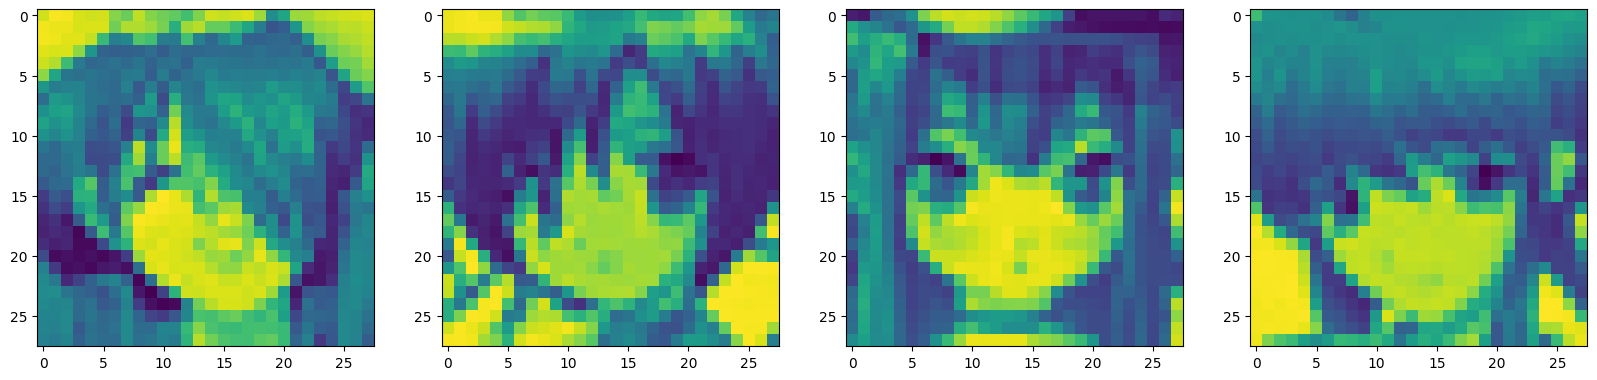

In [95]:
# Visualize some sample images
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample = image_array[idx]
    print("Sample shape:", sample.shape)
    ax[idx].imshow(Image.fromarray(sample, 'L'))  # Makes it easier to visualize

plt.show()

## Creating the Models

In this section, we will define the generator and discriminator models that will be used in our GAN.

### Generator Model

The generator model takes in random noise and generates images. It uses a series of dense and convolutional layers to upsample the input noise to the desired image size. The goal of the generator is to create images that are indistinguishable from real images to fool the discriminator.

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [97]:
def build_generator():
    model = Sequential()

    # Takes in random values and reshapes them to 7x7x128
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsampling block 1
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [98]:
generator = build_generator()

In [99]:
# Generate some images without training
img = generator.predict(np.random.randn(4, 128, 1))
print("Generated images shape:", img.shape)

1/1 [==============================] - 0s 135ms/step
Generated images shape: (4, 28, 28, 1)


### Visualizing Generated Images Without Training

Before training the generator model, we visualize the generated images to see the initial output. These images are expected to be random noise since the generator has not yet learned to produce realistic images.

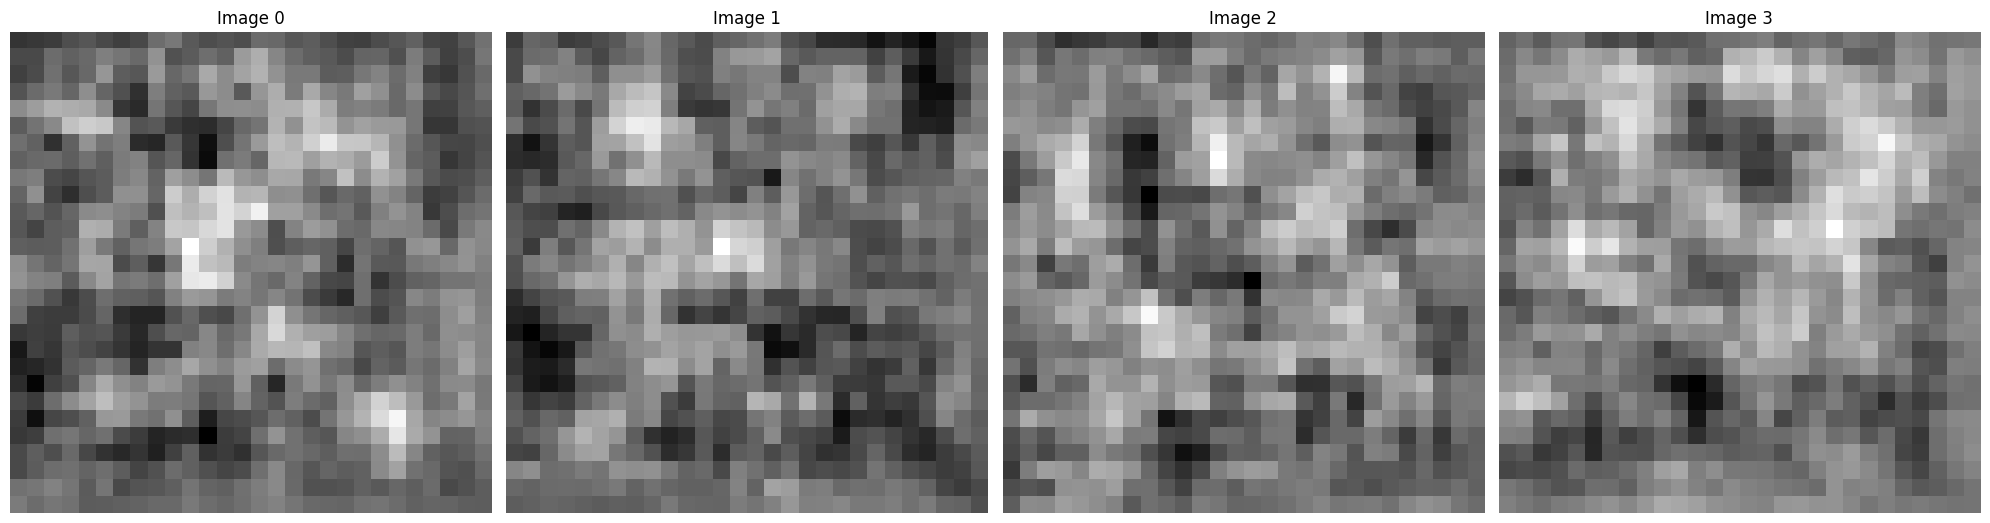

In [100]:
# Visualize generated images without training
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img), cmap='gray')  # Makes it easier to visualize
    ax[idx].title.set_text(f"Image {idx}")
    ax[idx].axis('off')  # Hide the axes ticks

plt.tight_layout()
plt.show()

### Discriminator Model

The discriminator model evaluates the authenticity of the generated images. It uses a series of convolutional layers to classify images as real or fake. The goal of the discriminator is to correctly identify real images from the training data and fake images generated by the generator.

In [101]:
def build_discriminator():
    model = Sequential()

    # First Convolution
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Convolution
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Convolution
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Convolution
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten the nodes then pass to dense layer with activation function
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model


In [102]:
discriminator = build_discriminator()

## Training Loop

The training loop involves alternating between training the discriminator and the generator. The discriminator is trained to distinguish between real and fake images, while the generator is trained to produce images that can fool the discriminator. Here is how the training process works:

1. Generate fake images using the generator.
2. Combine fake images with real images from the dataset.
3. Train the discriminator on this combined dataset to distinguish between real and fake images.
4. Generate new fake images and pass them through the discriminator.
5. Train the generator to improve its ability to fool the discriminator.

In [103]:
from tensorflow.keras.optimizers import Adam # Optimizer for both
from tensorflow.keras.losses import BinaryCrossentropy # Loss for both

We are using BinaryCrossEntropy as the discirminator model is a binary classification model, so this loss function allows us to quantify how well the model is able to differentiate between real and fake images.

In [104]:
# Defining the optimizers and Loss functions for generator and discriminator model
g_opt = Adam(learning_rate=0.00015) # higer learning rate becasue it is slow in learning
d_opt = Adam(learning_rate=0.00001) # lower learning rate so it learns at the same rate as generative model
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()


In [105]:
# Importing the base model class so we can subclass it for our training step
from tensorflow.keras.models import Model

In [106]:
class AnimeGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):

    # Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    # Create attributes for generative and discriminative
    self.generator = generator
    self.discriminator = discriminator



  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    # Create attributes for losses and optimizers for our genertaive and discriminative model
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    # Getting data
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Train discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)


      # Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


      # Adding some noise to the True outputs (details in markdown below)
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      # Calculate Loss - BinaryCross
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    # Applying back propogation to trian weights for discriminative model
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    # Training the Generator model
    with tf.GradientTape() as g_tape:

      # Generating new images
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Creating the predicted labels
      predicted_labels = self.discriminator(gen_images, training=False)

      # Calculate Loss - trick to training to fake out the discriminator
      total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

    # Apply BackPropagation
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss":total_d_loss, "g_loss": total_g_loss}

In the code cell above we are carrying out the training step for our models. The main idea for training discirminator model is to have a set of values that are real and fake. As we have already set the labels for real images to be 0 and fake to be 1 we just need to put the values in the loss function. However, in order to slow down the training process so its learning rate is closer to generator model we add some additional noise and then concat that to the real info array, yhat_realfake, and test the loss of the discirmiantor on that.

In [107]:
animegan = AnimeGAN(generator, discriminator)

In [108]:
# Compile the model
animegan.compile(g_opt, d_opt, g_loss, d_loss)

## Callback

We use a callback to monitor the model's performance during training and to save generated images at the end of each epoch. This helps in visualizing the progress of the generator as it learns to create more realistic images.

In [109]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [110]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dims=128):
        self.num_img = num_img
        self.latent_dims = latent_dims
        self.output_dir = 'Generated'

        # Ensure the output directory exists
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dims, 1))
        generated_images = self.model.generator.predict(random_latent_vectors)
        generated_images *= 255
        # generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('Generated', f'generated_img_{epoch}_{i}.png'))

In [111]:
# Recommend 2000 epochs
hist = animegan.fit(ds, epochs=50, callbacks=[ModelMonitor()])

Epoch 1/50


497/497 [==============================] - 90s 177ms/step - d_loss: 0.5847 - g_loss: 0.7132
Epoch 2/50
497/497 [==============================] - 102s 205ms/step - d_loss: 0.4636 - g_loss: 0.8794
Epoch 3/50
497/497 [==============================] - 111s 223ms/step - d_loss: 0.4242 - g_loss: 1.0170
Epoch 4/50
497/497 [==============================] - 112s 225ms/step - d_loss: 0.3876 - g_loss: 0.9971
Epoch 5/50
497/497 [==============================] - 116s 233ms/step - d_loss: 0.3559 - g_loss: 1.0781
Epoch 6/50
497/497 [==============================] - 119s 240ms/step - d_loss: 0.3210 - g_loss: 1.2304
Epoch 7/50
497/497 [==============================] - 123s 247ms/step - d_loss: 0.2958 - g_loss: 2.1797
Epoch 8/50
497/497 [==============================] - 121s 244ms/step - d_loss: 0.2733 - g_loss: 2.6145
Epoch 9/50
497/497 [==============================] - 123s 247ms/step - d_loss: 0.2703 - g_loss: 2.6324
Epoch 10/50
497/497 [==============================] - 119s 239ms/step - d_l

## Testing and Analysis

Plot the learning process and evaluate the generator model by visualizing generated images. The loss graphs for the discriminator and generator provide insights into their training progress and stability.

### Plotting the Learning Process

The loss graphs for the discriminator and generator models help us understand how well each model is learning. Initially, we might see high loss values for both models. Over time, the generator's loss should decrease as it becomes better at creating realistic images, while the discriminator's loss might oscillate as it alternates between improving its ability to distinguish real from fake images.

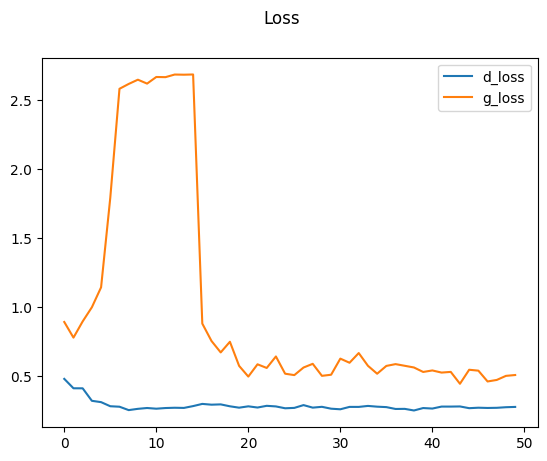

In [112]:
# Plot the learning process
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### Testing the Generator Model

Here we generate some images using the trained generator model and visualize them. The goal is to evaluate the generator's ability to produce realistic anime faces.

In [113]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))
print("Generated images shape:", imgs.shape)

1/1 [==============================] - 0s 25ms/step
Generated images shape: (16, 28, 28, 1)


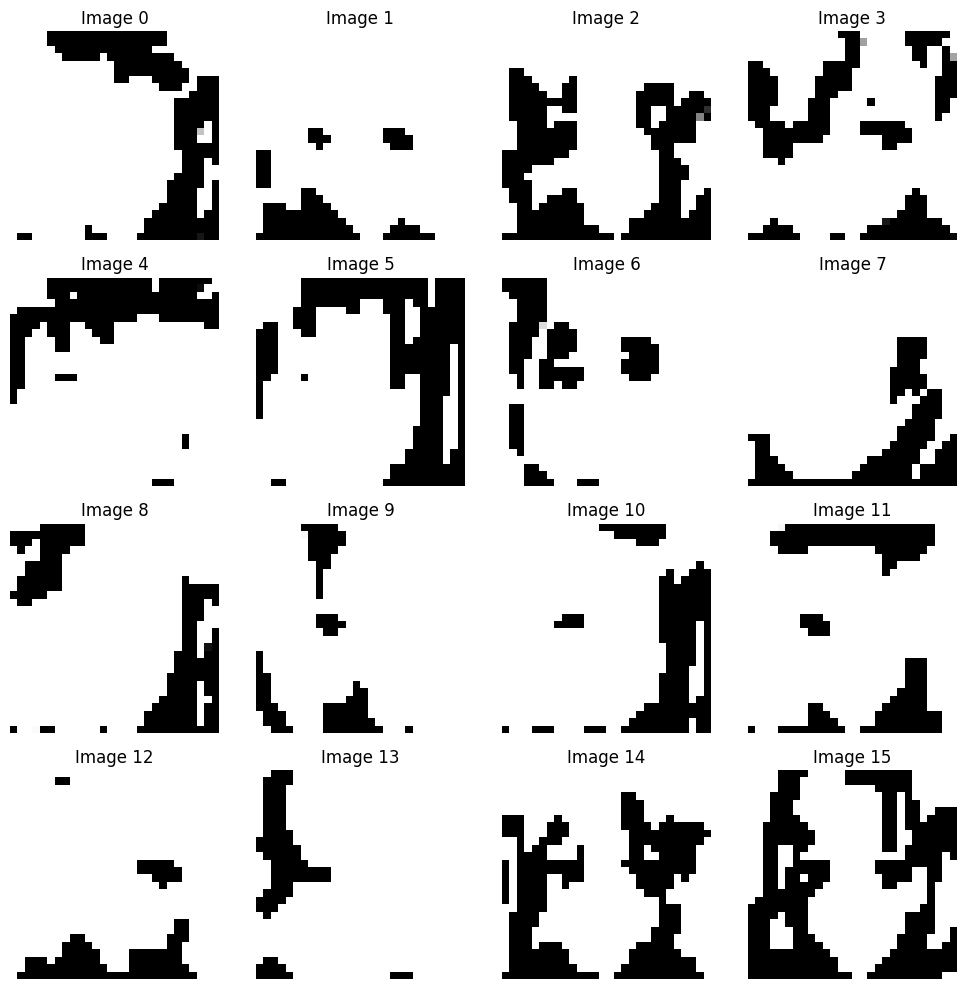

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 4x4 grid of subplots
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))

# Plot each generated image in the grid
for idx, img in enumerate(imgs):
    row = idx // 4
    col = idx % 4
    ax[row, col].imshow(np.squeeze(img), cmap='gray')  # Squeeze to remove single-dimensional entries from the shape
    ax[row, col].title.set_text(f"Image {idx}")
    ax[row, col].axis('off')  # Hide the axes ticks

plt.tight_layout()
plt.show()


## Comparing with Autoencoder

Autoencoders are another class of neural networks used for generating images. Unlike GANs, autoencoders consist of an encoder and a decoder. The encoder compresses the input image into a latent space representation, and the decoder reconstructs the image from this representation.

### Key Differences:

1. **Training Approach**:
   - **GANs**: Use adversarial training involving a generator and a discriminator.
   - **Autoencoders**: Train using reconstruction loss between the input and output images.

2. **Output Quality**:
   - **GANs**: Typically produce sharper and more realistic images due to adversarial training.
   - **Autoencoders**: Often result in blurrier images since they optimize for reconstruction accuracy.

3. **Training Stability**:
   - **GANs**: Training can be unstable due to the adversarial nature, requiring careful balancing.
   - **Autoencoders**: Generally more stable and easier to train.

### Why Use GANs for This Project?

The goal of this project is to generate high-quality anime face images. GANs are chosen over autoencoders because:
- They tend to produce more realistic and visually appealing images.
- The adversarial training helps the generator learn to produce images that are more difficult for the discriminator to distinguish from real images.

Despite the challenges in training GANs, their potential to create high-quality images makes them a better fit for this project compared to autoencoders.

(Code and image comaring with autoencoder is not included in this notebook. Will be added in future commits)

## Conclusion

In this project, we explored the use of Generative Adversarial Networks (GANs) to generate anime face images. Through the training process, we observed the following key points:

1. **Initial Training Phase**:
   - The generator loss (g_loss) initially increased, indicating the generator's struggle to produce realistic images. The discriminator (d_loss) remained relatively stable, showcasing its ability to distinguish between real and fake images effectively.

2. **Training Stability**:
   - After the initial phase, the generator loss dropped rapidly and then stabilized with some fluctuations. This stabilization indicates that the generator started producing better quality images, though it still faced challenges in consistently fooling the discriminator.

3. **Discriminator Performance**:
   - The discriminator loss remained low and stable throughout the training, suggesting that it effectively learned to identify real from generated images.

4. **Image Quality**:
   - The generated images improved in quality over time, but continuous fluctuations in the generator loss indicated varying image quality. Evaluating generated images visually at different epochs helped in assessing the model's performance more accurately than relying solely on loss values.

## Recommendations for Future Work

1. **Extended Training**:
   - Continue training for more epochs to allow the generator to improve further and produce more consistent results.

2. **Hyperparameter Tuning**:
   - Experiment with different learning rates, batch sizes, and network architectures to enhance model performance and stability.

3. **Balanced Training Steps**:
   - Adjust the number of training steps for the generator and discriminator within each epoch to ensure balanced learning progress.

4. **Color Image Generation**:
   - Modify the model to generate colored images, which may improve the realism and applicability of the generated images for video games and other applications.

## Final Thoughts

Generative Adversarial Networks have shown great potential in generating high-quality images, including anime faces. Despite the challenges in training and achieving stable convergence, the results demonstrate the feasibility and promise of GANs in creative applications such as game development and art generation. With continued improvements and refinements, GANs can become a valuable tool for artists and developers in various fields.

## References

Dataset: [Anime Face Dataset](https://www.kaggle.com/datasets/splcher/animefacedataset?resource=download)